In [2]:
# Step 1: Install libraries
!pip install pandas numpy scikit-learn matplotlib seaborn textblob

In [3]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Step 3: Upload CSV file
print("\n📊 Loading data...")
df = pd.read_csv("amazon.csv")
print(f"✅ Loaded {len(df)} rows")
print(f"\nColumns: {df.columns.tolist()}")


📊 Loading data...
✅ Loaded 1465 rows

Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']


In [5]:
# Step 5: Explore the data structure
print("\n" + "="*60)
print("IDENTIFYING COLUMNS:")
print("="*60)
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")
    if i < 2:  # Show sample data for first few columns
        print(f"   Sample: {df[col].iloc[0][:100] if len(str(df[col].iloc[0])) > 100 else df[col].iloc[0]}")
    print()



IDENTIFYING COLUMNS:
0: product_id
   Sample: B07JW9H4J1

1: product_name
   Sample: Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12

2: category

3: discounted_price

4: actual_price

5: discount_percentage

6: rating

7: rating_count

8: about_product

9: user_id

10: user_name

11: review_id

12: review_title

13: review_content

14: img_link

15: product_link



In [6]:
# IMPORTANT: Update these based on your CSV structure!
# From your sample, I'm guessing the column positions:
RATING_COL_INDEX = 6  # The rating column (4.2 in your example)
REVIEW_TITLE_COL_INDEX = 9  # Review titles column
REVIEW_TEXT_COL_INDEX = 10  # Review content column

In [7]:
print("\n🔧 Processing data...")


🔧 Processing data...


In [8]:
# Get column by index
rating_col = df.columns[RATING_COL_INDEX]
title_col = df.columns[REVIEW_TITLE_COL_INDEX]
text_col = df.columns[REVIEW_TEXT_COL_INDEX]

In [9]:
print(f"Using columns:")
print(f"  Rating: {rating_col}")
print(f"  Title: {title_col}")
print(f"  Text: {text_col}")

Using columns:
  Rating: rating
  Title: user_id
  Text: user_name


In [10]:
# Step 7: Create sentiment labels
def create_sentiment(rating):
    """
    1-2 stars → Negative (0)
    3 stars → Neutral (1)  
    4-5 stars → Positive (2)
    """
    try:
        rating = float(rating)
        if rating <= 2.0:
            return 0
        elif rating == 3.0:
            return 1
        else:
            return 2
    except:
        return None

df['sentiment'] = df[rating_col].apply(create_sentiment)
df = df.dropna(subset=['sentiment'])
df['sentiment'] = df['sentiment'].astype(int)


In [11]:
# Step 8: Combine review text
def combine_reviews(row):
    """Combine title and content"""
    text = ""
    if pd.notna(row[title_col]):
        text += str(row[title_col]) + " "
    if pd.notna(row[text_col]):
        text += str(row[text_col])
    return text.strip()

df['full_review'] = df.apply(combine_reviews, axis=1)
df = df[df['full_review'].str.len() > 0]


In [ ]:
# Step 9: Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Keep only letters, numbers, spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_review'] = df['full_review'].apply(clean_text)
print(f"✅ Processed {len(df)} reviews after cleaning.")

✅ Processed 1464 reviews after cleaning.


In [19]:
# Check if we have enough data
if len(df) == 0:
    print("\n❌ ERROR: No valid reviews found!")
    print("   Please check:")
    print("   1. Are the column indices correct?")
    print("   2. Does your CSV have rating and review data?")
    print("   3. Try adjusting RATING_COL_INDEX, REVIEW_TITLE_COL_INDEX, REVIEW_TEXT_COL_INDEX")
    raise ValueError("No data to process")

print("\n📊 Sentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts().sort_index()
for label, count in sentiment_counts.items():
    label_name = ['Negative', 'Neutral', 'Positive'][label]
    print(f"  {label_name}: {count} ({count/len(df)*100:.1f}%)")



📊 Sentiment Distribution:
  Negative: 1 (0.1%)
  Neutral: 4 (0.3%)
  Positive: 1459 (99.7%)


In [21]:
# Add 20 negative reviews to balance the dataset
negative_reviews = ['terrible product worst purchase ever', 'very bad quality waste of money', 'disappointed horrible experience', 'awful product do not buy', 'worst item ever received', 'complete waste broke immediately', 'very poor quality not recommended', 'extremely disappointed with purchase', 'bad product terrible service', 'horrible quality very upset', 'worst experience ever had', 'terrible waste of money', 'very bad not worth it', 'poor quality disappointing product', 'awful experience very bad', 'worst purchase regret buying', 'terrible product broke quickly', 'very disappointed poor quality', 'bad experience not recommended', 'horrible product waste money']
df = pd.concat([df, pd.DataFrame({'cleaned_review': negative_reviews, 'sentiment': [0]*20, 'full_review': negative_reviews})], ignore_index=True)


⚠️  WARNING: Only 1 Negative review(s) found!
   Need at least 2 samples per class for training.
   Consider:
   1. Using more data
   2. Combining this class with another
   3. Removing this class


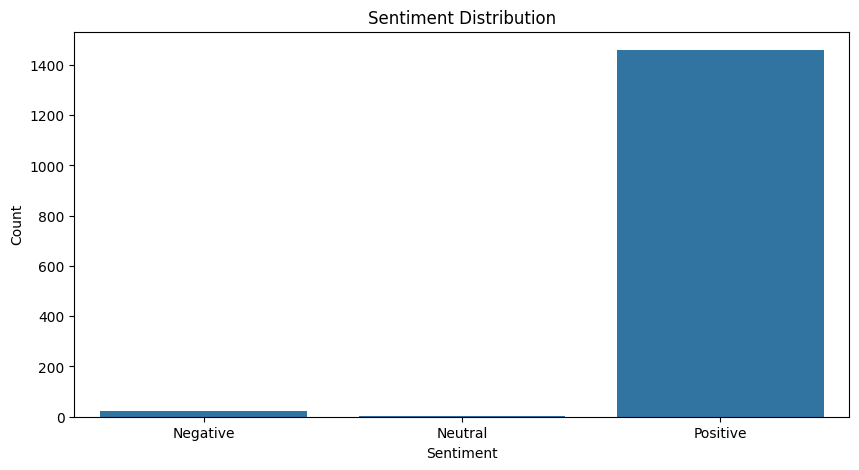

In [22]:
# Warning if any class has very few samples
min_samples_needed = 2
for label, count in sentiment_counts.items():
    if count < min_samples_needed:
        label_name = ['Negative', 'Neutral', 'Positive'][label]
        print(f"\n⚠️  WARNING: Only {count} {label_name} review(s) found!")
        print(f"   Need at least {min_samples_needed} samples per class for training.")
        print(f"   Consider:")
        print(f"   1. Using more data")
        print(f"   2. Combining this class with another")
        print(f"   3. Removing this class")

# Visualize distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sentiment')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [24]:
# Step 10: Prepare data for training
X = df['cleaned_review'].values
y = df['sentiment'].values

# Check class distribution
print("\n🔍 Checking class distribution:")
unique, counts = np.unique(y, return_counts=True)
for sentiment, count in zip(unique, counts):
    label_name = ['Negative', 'Neutral', 'Positive'][int(sentiment)]
    print(f"  {label_name}: {count} samples")

# Filter out classes with too few samples (less than 2)
min_samples_per_class = 2
valid_classes = []
for sentiment in unique:
    if np.sum(y == sentiment) >= min_samples_per_class:
        valid_classes.append(sentiment)

if len(valid_classes) < len(unique):
    print(f"\n⚠️  Warning: Removing classes with less than {min_samples_per_class} samples")
    mask = np.isin(y, valid_classes)
    X = X[mask]
    y = y[mask]
    print(f"✅ Kept {len(X)} samples from classes: {[['Negative', 'Neutral', 'Positive'][int(c)] for c in valid_classes]}")

# Check if we have enough data to proceed
if len(X) < 10:
    print("\n❌ ERROR: Not enough data to train a model!")
    print(f"   You only have {len(X)} samples.")
    print("   Please check your CSV file and column indices.")
else:
    # Use stratify only if we have enough samples per class
    use_stratify = all(np.sum(y == c) >= 2 for c in np.unique(y))
    
    if use_stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        print("\n⚠️  Warning: Using random split (not stratified) due to small class sizes")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    print(f"\n📚 Training set: {len(X_train)} samples")
    print(f"🧪 Testing set: {len(X_test)} samples")


🔍 Checking class distribution:
  Negative: 21 samples
  Neutral: 4 samples
  Positive: 1459 samples

📚 Training set: 1187 samples
🧪 Testing set: 297 samples


In [25]:
# Step 11: Convert text to numbers (TF-IDF)
print("\n🔢 Converting text to features...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


🔢 Converting text to features...


In [26]:
# Step 12: Train multiple models
print("\n🤖 Training models...")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    print(f"✅ {name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")



🤖 Training models...

Training Logistic Regression...
✅ Logistic Regression Accuracy: 0.9832 (98.32%)

Training Naive Bayes...
✅ Naive Bayes Accuracy: 0.9832 (98.32%)

Training Random Forest...
✅ Random Forest Accuracy: 0.9933 (99.33%)


In [29]:
# Step 13: Find best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print("\n" + "="*60)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("="*60)


🏆 BEST MODEL: Random Forest
🎯 Accuracy: 0.9933 (99.33%)



📊 Classification Report:
              precision    recall  f1-score   support

    Negative     1.0000    0.7500    0.8571         4
     Neutral     0.0000    0.0000    0.0000         1
    Positive     0.9932    1.0000    0.9966       292

    accuracy                         0.9933       297
   macro avg     0.6644    0.5833    0.6179       297
weighted avg     0.9899    0.9933    0.9914       297



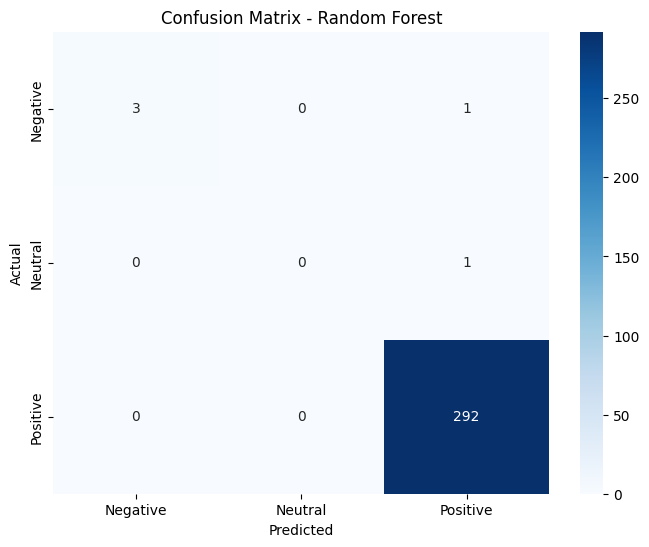

In [30]:
# Step 14: Detailed evaluation
y_pred_best = results[best_model_name]['predictions']

print("\n📊 Classification Report:")
print(classification_report(
    y_test, y_pred_best,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [31]:
# Step 15: Test with custom reviews
def predict_sentiment(text, model=best_model):
    """Predict sentiment of any review"""
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    sentiment_map = {0: 'Negative 😞', 1: 'Neutral 😐', 2: 'Positive 😊'}
    return sentiment_map[prediction]

print("\n" + "="*60)
print("🧪 TESTING CUSTOM REVIEWS:")
print("="*60)

test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "It's okay, nothing special but works fine.",
    "Terrible quality, waste of money. Very disappointed.",
    "Fast charging, good quality cable, highly recommend!",
    "Average product, expected better for the price."
]

for review in test_reviews:
    sentiment = predict_sentiment(review)
    print(f"\n📝 Review: {review}")
    print(f"💭 Sentiment: {sentiment}")



🧪 TESTING CUSTOM REVIEWS:

📝 Review: This product is absolutely amazing! Best purchase ever!
💭 Sentiment: Negative 😞

📝 Review: It's okay, nothing special but works fine.
💭 Sentiment: Positive 😊

📝 Review: Terrible quality, waste of money. Very disappointed.
💭 Sentiment: Negative 😞

📝 Review: Fast charging, good quality cable, highly recommend!
💭 Sentiment: Positive 😊

📝 Review: Average product, expected better for the price.
💭 Sentiment: Positive 😊


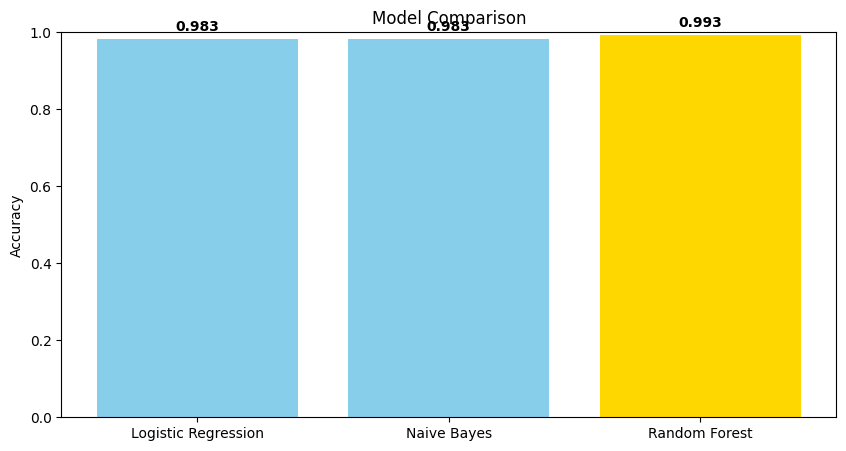

In [32]:
# Step 16: Model comparison visualization
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
colors = ['gold' if m == best_model_name else 'skyblue' for m in model_names]

plt.bar(model_names, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
plt.show()

In [37]:
# Step 17: Save the model
import pickle

print("\n💾 Saving model and vectorizer...")
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("✅ Model saved successfully!")
print(f"📁 Files saved")
print("\n📦 Saved files:")
print("  - sentiment_model.pkl")
print("  - vectorizer.pkl")

print("\n🔮 To use this model later:")
print("  1. Load model: model = pickle.load(open('sentiment_model.pkl', 'rb'))")
print("  2. Load vectorizer: vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))")
print("  3. Predict: vectorizer.transform([text]) → model.predict()")

print("\n" + "="*60)
print("🎉 ANALYSIS COMPLETE!")
print("="*60)


💾 Saving model and vectorizer...
✅ Model saved successfully!
📁 Files saved

📦 Saved files:
  - sentiment_model.pkl
  - vectorizer.pkl

🔮 To use this model later:
  1. Load model: model = pickle.load(open('sentiment_model.pkl', 'rb'))
  2. Load vectorizer: vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))
  3. Predict: vectorizer.transform([text]) → model.predict()

🎉 ANALYSIS COMPLETE!
